<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/master/kap7-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kapitel 7: Neuronale Netzwerke - Bilderkennung

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
colors = 'bwr'#['b','y','r']
CMAP = colors#plt.cm.rainbow

In [5]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [6]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [7]:
import keras
print(keras.__version__)

2.4.3


In [8]:
import pandas as pd
print(pd.__version__)

1.0.5


## Laden und Vorbereiten der Bild-Daten

In [9]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  4826k      0 --:--:-- --:--:-- --:--:-- 4814k


In [10]:
!ls -l speed-limit-signs

total 28
drwxr-xr-x 2 root root 4096 Aug 31 13:32 0
drwxr-xr-x 2 root root 4096 Aug 31 13:32 1
drwxr-xr-x 2 root root 4096 Aug 31 13:32 2
drwxr-xr-x 2 root root 4096 Aug 31 13:32 3
drwxr-xr-x 2 root root 4096 Aug 31 13:32 4
drwxr-xr-x 2 root root 4096 Aug 31 13:32 5
-rw-r--r-- 1 root root  380 Aug 31 13:34 README.md


In [11]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

# Big Kudos to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

In [12]:
import os
from skimage import data, io, filters

ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
type = ".ppm"

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d))]
# Loop through the label directories and collect the data in
# two lists, labels and images.
labels = []
images = []
for d in directories:
    label_dir = os.path.join(data_dir, d)
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for f in file_names:
        images.append(io.imread(f))
        labels.append(int(d))

images, labels = np.array(images), np.array(labels)

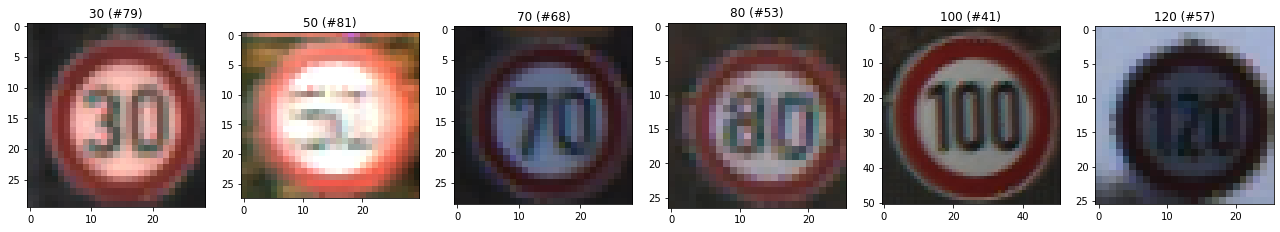

In [13]:
import matplotlib
import matplotlib.pyplot as plt

label_names = ['30', '50', '70', '80', '100', '120']

plt.figure(figsize=(30, 15))

unique_values, counts = np.unique(labels, return_counts=True)
classes = len(unique_values)

i = 1
for label in unique_values:
    # Pick the first image for each label.
    image = images[np.where(labels == label)[0][0]]
    plt.subplot(1, 8, i)
    plt.title("{0} (#{1})".format(label_names[label], counts[label]))
    i += 1
    plt.imshow(image)

In [14]:
import skimage.transform

images_64 = np.array([skimage.transform.resize(image, (64, 64)) for image in images])

## Modell-Architektur

In [15]:
y = np.array(labels)
X = np.array(images_64)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [16]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [17]:
model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)      

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Zuerst testen wir unser Modell, ob wir es überhaupt trainiert bekommen, indem wir auf einer kleinen Menge von Daten overfitten

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [20]:
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

In [21]:
%time model.fit(X_train, y_train, epochs=100, validation_split=0.3)

Epoch 1/100
1/1 [==============================] - 0s 230ms/step - loss: 1.7902 - accuracy: 0.1200 - val_loss: 2.3233 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 1.8166 - accuracy: 0.2800 - val_loss: 1.7944 - val_accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 1.7883 - accuracy: 0.2800 - val_loss: 1.7984 - val_accuracy: 0.2500
Epoch 4/100
1/1 [==============================] - 0s 24ms/step - loss: 1.7831 - accuracy: 0.2800 - val_loss: 1.8296 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 1.7622 - accuracy: 0.2800 - val_loss: 1.9394 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 24ms/step - loss: 1.7196 - accuracy: 0.2800 - val_loss: 2.4580 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 1.8459 - accuracy: 0.2800 - val_loss: 1.9186 - val_accuracy: 0.0000e+00

## Das sieht gut aus, nun versuchen wir es mit dem kompletten Datensatz ohne Overfitting und mit Dropout

In [22]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

drop_out = 0.6

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [23]:
model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)      

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# wenn die Ergebnisse lange Zeit schlecht bleiben, brechen wir lieber ab
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1)

In [27]:
# auf Colab haben wir GPU support angeschaltet, d.h. auch dieses Training kann sehr schnell gehen
# auf einem lokalen Recher ohne GPU kann sowas aber locker 2 Stunden oder mehr laufen
# BATCH_SIZE = 500
BATCH_SIZE = 32
%time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/500
8/8 [==============================] - 0s 62ms/step - loss: 1.7730 - accuracy: 0.2149 - val_loss: 1.7852 - val_accuracy: 0.1148
Epoch 2/500
8/8 [==============================] - 0s 18ms/step - loss: 1.7330 - accuracy: 0.2231 - val_loss: 1.7875 - val_accuracy: 0.0984
Epoch 3/500
8/8 [==============================] - 0s 18ms/step - loss: 1.6964 - accuracy: 0.2314 - val_loss: 1.7747 - val_accuracy: 0.1475
Epoch 4/500
8/8 [==============================] - 0s 18ms/step - loss: 1.7225 - accuracy: 0.2521 - val_loss: 1.7917 - val_accuracy: 0.1639
Epoch 5/500
8/8 [==============================] - 0s 18ms/step - loss: 1.7147 - accuracy: 0.2521 - val_loss: 1.7674 - val_accuracy: 0.1475
Epoch 6/500
8/8 [==============================] - 0s 18ms/step - loss: 1.6788 - accuracy: 0.2893 - val_loss: 1.7639 - val_accuracy: 0.1803
Epoch 7/500
8/8 [==============================] - 0s 17ms/step - loss: 1.6738 - accuracy: 0.2934 - val_loss: 1.7725 - val_accuracy: 0.1967
Epoch 8/500
8/8 [===

# Bewertung

In [28]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

10/10 [==============================] - 0s 10ms/step - loss: 0.0263 - accuracy: 0.9934


(0.026338381692767143, 0.9933993220329285)

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

3/3 [==============================] - 0s 4ms/step - loss: 0.0749 - accuracy: 0.9737


(0.07488446682691574, 0.9736841917037964)

# Sichern des Modells

In [30]:
!rm -r models
!mkdir models

In [31]:
model.save('models/conv-vgg.hdf5')

In [32]:
!ls -lh models

total 55M
-rw-r--r-- 1 root root 55M Aug 31 13:35 conv-vgg.hdf5


In [33]:
# !curl --upload-file ./models/conv-vgg.hdf5 https://transfer.sh/conv-vgg.hdf5

# Ausprobieren auf ein paar Test-Daten

In [34]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([5, 2, 0, 5, 0, 5, 2, 1, 0, 5])

In [35]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

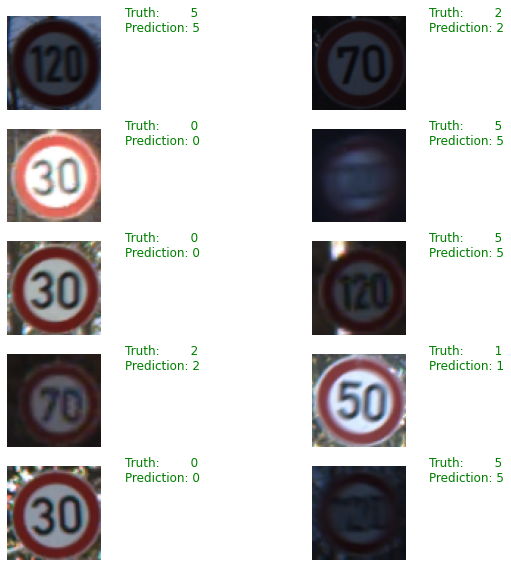

In [36]:
display_prediction(sample_images, ground_truth, predicted_categories)